## Imports

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from copy import deepcopy

In [2]:
# Pretty plots
import seaborn as sns
import matplotlib
matplotlib.rcParams['text.usetex'] = True
matplotlib.rc('font',family='serif', serif=['Palatino'])
sns.set(font='serif', font_scale=1.4)
sns.set_style("white", {
        "font.family": "serif",
        "font.weight": "normal",
        "font.serif": ["Times", "Palatino", "serif"],
        'axes.facecolor': 'white',
        'lines.markeredgewidth': 1})

def setup_plot():
    fig = plt.figure(dpi=100, figsize=(5.0,3.0))
    ax = plt.subplot(111)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.tick_params(axis = 'both', which = 'major', labelsize = 15)
    ax.tick_params(axis = 'both', which = 'minor', labelsize = 15)
    ax.tick_params(direction='in')

In [3]:
from src.models import Model, LinearModel
from src.oadam import OAdam, add_weight_decay, net_to_list
from src.learners.bc import BC
from src.learners.doubil import DoubIL
from src.learners.residuil import ResiduIL

## LQG System

In [66]:
import src.lqg

In [67]:
K_star = src.lqg.solve(src.lqg.A, src.lqg.B, src.lqg.Q, src.lqg.R)
print(K_star)
def expert(s):
    if s.size == 2:
        return K_star @ s
    else:
        return s @ K_star.T

Converged with horizon 34
[[-2.57543063 -3.43994714]]


In [68]:
def learner(K, s):
    if s.size == 2:
        return K @ s
    else:
        return s @ K.T

In [69]:
denoised_expert_trajs = []
for _ in range(100):
    s_0 = np.random.normal(size=(2, 1))
    s_traj, a_traj, _ = src.lqg.rollout(s_0, expert)
    denoised_expert_trajs.append((s_traj, a_traj))

Text(0, 0.5, 'pos.')

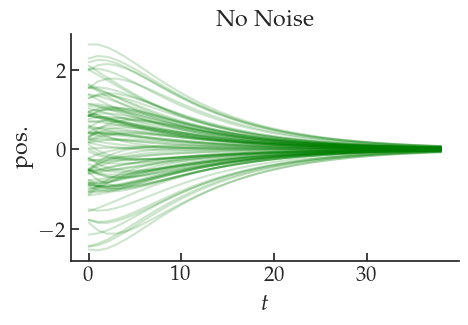

In [70]:
setup_plot()
for (pos, vel) in denoised_expert_trajs:
    plt.plot(np.arange(len(pos)), pos[:, 0], color="green", alpha=0.2)
plt.title("No Noise")
plt.xlabel("$t$")
plt.ylabel("pos.")

In [71]:
expert_trajs_1 = []
for _ in range(20):
    s_0 = np.random.normal(size=(2, 1))
    s_traj, a_traj, _ = src.lqg.noisy_rollout(s_0, expert, num_steps_cnfnd=1)
    expert_trajs_1.append((s_traj, a_traj))
expert_trajs_5 = []
for _ in range(20):
    s_0 = np.random.normal(size=(2, 1))
    s_traj, a_traj, _ = src.lqg.noisy_rollout(s_0, expert, num_steps_cnfnd=5)
    expert_trajs_5.append((s_traj, a_traj))
expert_trajs_10 = []
for _ in range(20):
    s_0 = np.random.normal(size=(2, 1))
    s_traj, a_traj, _ = src.lqg.noisy_rollout(s_0, expert, num_steps_cnfnd=10)
    expert_trajs_10.append((s_traj, a_traj))

Text(0, 0.5, 'pos.')

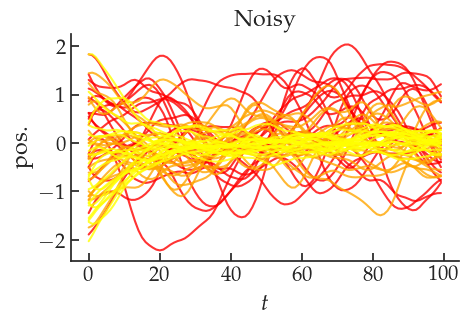

In [72]:
setup_plot()
for (pos, vel) in expert_trajs_10:
    plt.plot(np.arange(len(pos)), pos[:, 0], alpha=0.8, color="red")
for (pos, vel) in expert_trajs_5:
    plt.plot(np.arange(len(pos)), pos[:, 0], alpha=0.8, color="orange")
for (pos, vel) in expert_trajs_1:
    plt.plot(np.arange(len(pos)), pos[:, 0], alpha=0.8, color="yellow")
plt.title("Noisy")
plt.xlabel("$t$")
plt.ylabel("pos.")

In [84]:
kappas = []
Js = []
for i in range(10):
    kappas_i = []
    for num_steps_cnfnd in range(1, 30):
        expert_trajs = []
        for _ in range(1000):
            s_0 = np.random.normal(size=(2, 1))
            s_traj, a_traj, _ = src.lqg.noisy_rollout(s_0, expert, num_steps_cnfnd=num_steps_cnfnd)
            expert_trajs.append((s_traj, a_traj))
        S_past = np.concatenate([x[0][:-num_steps_cnfnd] for x in expert_trajs], axis=0)
        S_curr = np.concatenate([x[0][num_steps_cnfnd:] for x in expert_trajs], axis=0)
        A_curr = np.concatenate([x[1][num_steps_cnfnd:] for x in expert_trajs], axis=0)

        # compute kappa
        sigma = (S_curr.T @ S_curr) / len(S_curr)
        num = np.max(np.linalg.eig(sigma)[0])
        E_x_z = np.linalg.inv(S_past.T @ S_past) @ S_past.T @ S_curr
        V = ((S_past @ E_x_z).T @ (S_past @ E_x_z)) / len(S_past)
        denom = np.min(np.linalg.eig(V)[0])
        kappas_i.append(np.sqrt(num / denom))
    kappas.append(kappas_i)

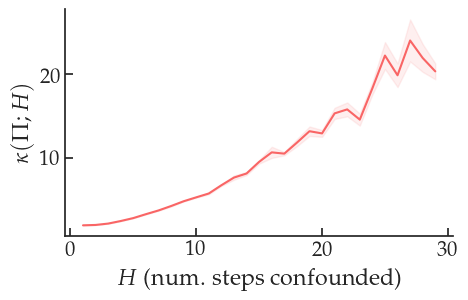

In [86]:
setup_plot()
plt.plot(list(range(1, len(kappas[0]) + 1)), np.mean(kappas, axis=0), color="#f96565")
plt.fill_between(list(range(1, len(kappas[0]) + 1)),
                 np.mean(kappas, axis=0) - (np.std(kappas, axis=0) / np.sqrt(len(kappas))),
                 np.mean(kappas, axis=0) + (np.std(kappas, axis=0) / np.sqrt(len(kappas))),
                 color = "#f96565",
                 alpha = 0.1)
plt.ylabel("$\kappa(\Pi; H)$")
plt.xlabel("$H$ (num. steps confounded)")
plt.savefig("figs/length_cnfnd.pdf", bbox_inches='tight')

In [10]:
# pi_BC = BC(expert_trajs, LinearModel(2, 1), lr=3e-4)
# K_BC = [x.detach().numpy() for x in pi_BC.parameters()][0].reshape(-1)
# print('Param. MSE =', np.linalg.norm(K_star - K_BC))

BC Data (3900, 2) (3900, 1)
Param. MSE = 1.1004107751234313


In [11]:
# pi_DoubIL = DoubIL(expert_trajs, LinearModel(2, 1), src.lqg.dynamics, pi_BC=pi_BC, lr=3e-4)
# K_DoubIL = [x.detach().numpy() for x in pi_DoubIL.parameters()][0].reshape(-1)
# print('Param. MSE =', np.linalg.norm(K_star - K_DoubIL))

Done w/ BC
IV Data (3800, 2) (3800, 1)
Param. MSE = 0.09624049368265526


In [12]:
# pi_ResiduIL = ResiduIL(expert_trajs, LinearModel(2, 1), LinearModel(2, 1), lr=3e-4)
# K_ResiduIL = [x.detach().numpy() for x in pi_ResiduIL.parameters()][0].reshape(-1)
# print('Param. MSE =', np.linalg.norm(K_star - K_ResiduIL))

Param. MSE = 0.13930709378053507


## LunarLander

In [4]:
from src.lunar_lander_env import LunarLanderContinuous
from src.lunar_lander_utils import T, dynamics, rollout, noisy_rollout, eval_policy

In [5]:
env = LunarLanderContinuous(confounding=False, fixed_terrain=True)

In [6]:
from stable_baselines3 import PPO
expert_net = PPO.load("src/experts/ll_expert")
def expert(s):
    return expert_net.predict(s, deterministic=True)[0]

In [7]:
env.reset()
denoised_expert_trajs = []
Js = []
for _ in range(25):
    s_traj, a_traj, J = rollout(lambda s: expert_net.predict(s, deterministic=True), env)
    denoised_expert_trajs.append((s_traj, a_traj))
    Js.append(J)

In [8]:
env.reset()
expert_trajs2 = []
Js = []
for _ in range(25):
    s_traj, a_traj, J = noisy_rollout(lambda s: expert_net.predict(s, deterministic=True), env)
    expert_trajs2.append((s_traj, a_traj))
    Js.append(J)

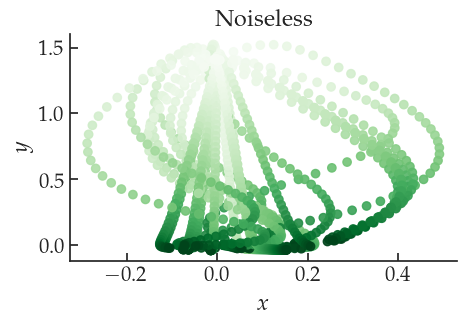

In [9]:
setup_plot()
for (s_traj, _) in denoised_expert_trajs:
    plt.scatter(s_traj[::5, 0,],
                s_traj[::5, 1],
                c=np.arange(len(s_traj[::5, 0,])),
                cmap='Greens',
                alpha=0.9)
plt.title("Noiseless")
plt.ylabel("$y$")
plt.xlabel("$x$")
plt.show()

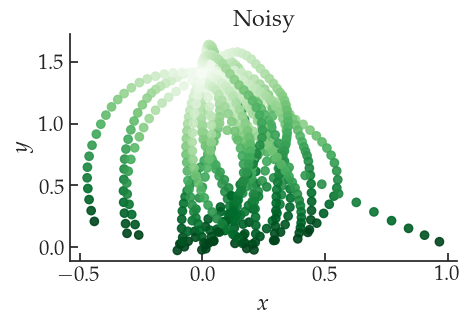

In [10]:
setup_plot()
for (s_traj, _) in expert_trajs2:
    plt.scatter(s_traj[::5, 0,],
                s_traj[::5, 1],
                c=np.arange(len(s_traj[::5, 0,])),
                cmap='Greens',
                alpha=0.9)
plt.title("Noisy")
plt.ylabel("$y$")
plt.xlabel("$x$")
plt.show()

In [11]:
# Generate test set
env.reset()
denoised_test = []
for _ in range(100):
    s_traj, _, _ = rollout(lambda s: expert_net.predict(s, deterministic=True), env)
    denoised_test.append((s_traj, expert(s_traj)))
np.savez("data/denoised_test", denoised_test)

In [12]:
# env.reset()
noisy_test = []
for _ in range(100):
    s_traj, _, _ = noisy_rollout(lambda s: expert_net.predict(s, deterministic=True), env)
    noisy_test.append((s_traj, expert(s_traj)))
np.savez("data/noisy_test", noisy_test)

In [13]:
# Generate training sets
for i in range(5):
    for size in [10, 20, 30, 40, 50]:
        trajs = []
        for _ in range(size):
            s_traj, a_traj, _ = noisy_rollout(lambda s: expert_net.predict(s, deterministic=True), env)
            trajs.append((s_traj, a_traj))
        np.savez("data/train_{0}_{1}".format(size, i), trajs)

In [14]:
denoised_test = np.load("./data/denoised_test.npz", allow_pickle=True)["arr_0"]
noisy_test = np.load("./data/noisy_test.npz", allow_pickle=True)["arr_0"]

In [15]:
def mse(pi, dataset):
    total = 0
    for (s_traj, a_traj) in dataset:
        total += np.linalg.norm(pi(s_traj) - a_traj)
    return total / len(dataset)

In [16]:
bc_mse_noisy = []
bc_mse_denoised = []

doubil_mse_noisy = []
doubil_mse_denoised = []

residuil_mse_noisy = []
residuil_mse_denoised = []

In [75]:
for i in range(5):
    bc_mse_noisy_i = []
    bc_mse_denoised_i = []

    doubil_mse_noisy_i = []
    doubil_mse_denoised_i = []

    residuil_mse_noisy_i = []
    residuil_mse_denoised_i = []
    
    for size in [10, 20, 30, 40, 50]:
        expert_trajs = np.load("./data/train_{0}_{1}.npz".format(size, i), allow_pickle=True)["arr_0"]
    
        pi_BC = BC(expert_trajs, Model(env.observation_space.shape[0], env.action_space.shape[0]))
        bc_mse_noisy_i.append(mse(lambda s: pi_BC(torch.from_numpy(s).float()).detach().numpy(), noisy_test))
        bc_mse_denoised_i.append(mse(lambda s: pi_BC(torch.from_numpy(s).float()).detach().numpy(), denoised_test))
        print('BC',
              size,
              bc_mse_noisy_i[-1],
              bc_mse_denoised_i[-1])
        
        pi_DoubIL = DoubIL(expert_trajs,
                   Model(env.observation_space.shape[0], env.action_space.shape[0]),
                   lambda a, b: dynamics(a, b, env), pi_BC=pi_BC)
        doubil_mse_noisy_i.append(mse(lambda s: pi_DoubIL(torch.from_numpy(s).float()).detach().numpy(), noisy_test))
        doubil_mse_denoised_i.append(mse(lambda s: pi_DoubIL(torch.from_numpy(s).float()).detach().numpy(), denoised_test))
        print('doubil',
              size,
              doubil_mse_noisy_i[-1],
              doubil_mse_denoised_i[-1])
        
        pi_ResiduIL = ResiduIL(expert_trajs,
                       Model(env.observation_space.shape[0], env.action_space.shape[0]),
                       Model(env.observation_space.shape[0], env.action_space.shape[0]))
        residuil_mse_noisy_i.append(mse(lambda s: pi_ResiduIL(torch.from_numpy(s).float()).detach().numpy(), noisy_test))
        residuil_mse_denoised_i.append(mse(lambda s: pi_ResiduIL(torch.from_numpy(s).float()).detach().numpy(), denoised_test))
        print('residuil',
              size,
              residuil_mse_noisy_i[-1],
              residuil_mse_denoised_i[-1])
        
    bc_mse_noisy.append(bc_mse_noisy_i)
    bc_mse_denoised.append(bc_mse_denoised_i)
    np.savez("data/bc_mse_noisy", bc_mse_noisy)
    np.savez("data/bc_mse_denoised", bc_mse_denoised)
    
    residuil_mse_noisy.append(residuil_mse_noisy_i)
    residuil_mse_denoised.append(residuil_mse_denoised_i)
    np.savez("data/residuil_mse_noisy", residuil_mse_noisy)
    np.savez("data/residuil_mse_denoised", residuil_mse_denoised)

    doubil_mse_noisy.append(doubil_mse_noisy_i)
    doubil_mse_denoised.append(doubil_mse_denoised_i)
    np.savez("data/doubil_mse_noisy", doubil_mse_noisy)
    np.savez("data/doubil_mse_denoised", doubil_mse_denoised)

## Confounding Test Figure

In [18]:
import matplotlib.image as image
im = image.imread("./figs/ufo.png")

In [30]:
# expert_trajs = np.load("./data/train_{0}_{1}.npz".format(20, 3), allow_pickle=True)["arr_0"]

In [31]:
# pi_ResiduIL = ResiduIL(expert_trajs,
#                        Model(env.observation_space.shape[0], env.action_space.shape[0]),
#                        Model(env.observation_space.shape[0], env.action_space.shape[0]))

In [32]:
# pi_BC = BC(expert_trajs, Model(env.observation_space.shape[0], env.action_space.shape[0]))

BC Data (3360, 6) (3360, 2)


In [48]:
env.reset()
expert_trajs2 = []
for _ in range(25):
    s_traj, a_traj, _ = noisy_rollout(lambda s: expert_net.predict(s, deterministic=True), env)
    expert_trajs2.append((s_traj, a_traj))

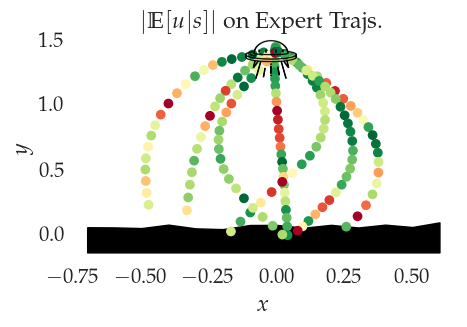

In [65]:
setup_plot()
for (s_traj, _) in expert_trajs2[0:7]:
    bc_preds = pi_BC(torch.from_numpy(s_traj).float()).detach().numpy()
    iv_preds = pi_ResiduIL(torch.from_numpy(s_traj).float()).detach().numpy()
    confounding = np.linalg.norm(bc_preds - iv_preds, axis=1)
    plt.scatter(s_traj[::5, 0,],
                s_traj[::5, 1],
                c=-confounding[::5],
                cmap='RdYlGn',
                alpha=1.0)

plt.fill_between(np.arange(-0.7, 0.7, 0.1),
                 np.arange(-0.7, 0.7, 0.1) * 0 - 0.15,
                 np.arange(-0.7, 0.7, 0.1) * 0 + 0.05 + 0.02 * np.random.normal(size=(len(np.arange(-0.7, 0.7, 0.1)))),
                 color = "black",
                 alpha = 1.0,
                 zorder=-1)

xrng=plt.xlim()
yrng=plt.ylim()
scale=.2 
plt.imshow(im,aspect='auto',extent=(xrng[0] + 0.6 ,xrng[0] + scale*(xrng[1]-xrng[0]) + 0.6, yrng[0] + 1.35, yrng[0] + scale*(yrng[1]-yrng[0]) + 1.45 ), zorder=1)
plt.xlim(xrng)
plt.ylim(yrng)

plt.title("$|\mathbb{E}[u|s]|$ on Expert Trajs.")
plt.ylabel("$y$")
plt.xlabel("$x$")
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().tick_params(bottom=False, left=False)
plt.savefig("figs/test.pdf", bbox_inches='tight')